In [2]:
%matplotlib notebook 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:

# filename = 'GOOG-year.csv'
filename = 'GOOG.csv'

df = pd.read_csv(f'../dataset/{filename}')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-10-02,959.979980,962.539978,947.840027,953.270020,953.270020,1283400
1,2017-10-03,954.000000,958.000000,949.140015,957.789978,957.789978,888300
2,2017-10-04,957.000000,960.390015,950.690002,951.679993,951.679993,952400
3,2017-10-05,955.489990,970.909973,955.179993,969.960022,969.960022,1213800
4,2017-10-06,966.700012,979.460022,963.359985,978.890015,978.890015,1173900


In [4]:
count = int(np.ceil(len(df) * 0.1))
signals = pd.DataFrame(index=df.index)
signals['signal'] = 0.0
signals['trend'] = df['Close']
signals['RollingMax'] = (signals.trend.shift(1).rolling(count).max())
signals['RollingMin'] = (signals.trend.shift(1).rolling(count).min())
signals.loc[signals['RollingMax'] < signals.trend, 'signal'] = -1
signals.loc[signals['RollingMin'] > signals.trend, 'signal'] = 1
signals

,signal,trend,RollingMax,RollingMin
0,0.0,953.270020,NaN,NaN
1,0.0,957.789978,NaN,NaN
2,0.0,951.679993,NaN,NaN
3,-1.0,969.960022,957.789978,951.679993
4,-1.0,978.890015,969.960022,951.679993
5,0.0,977.000000,978.890015,951.679993
6,0.0,972.599976,978.890015,969.960022
7,-1.0,989.250000,978.890015,972.599976
8,0.0,987.830017,989.250000,972.599976
9,-1.0,989.679993,989.250000,972.599976


In [5]:
def buy_stock(
    real_movement,
    signal,
    initial_money = 10000,
    max_buy = 1,
    max_sell = 1,
):
    """
    real_movement = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, 0 is sell
    initial_money = 1000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    """
    starting_money = initial_money
    states_sell = []
    states_buy = []
    current_inventory = 0

    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(
                'day %d: total balances %f, not enough money to buy a unit price %f'
                % (i, initial_money, real_movement[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print(
                'day %d: buy %d units at price %f, total balance %f'
                % (i, buy_units, buy_units * real_movement[i], initial_money)
            )
            states_buy.append(0)
        return initial_money, current_inventory

    for i in range(real_movement.shape[0] - int(0.025 * len(df))):
        state = signal[i]
        if state == 1:
            initial_money, current_inventory = buy(
                i, initial_money, current_inventory
            )
            states_buy.append(i)
        elif state == -1:
            if current_inventory == 0:
                    print('day %d: cannot sell anything, inventory 0' % (i))
            else:
                if current_inventory > max_sell:
                    sell_units = max_sell
                else:
                    sell_units = current_inventory
                current_inventory -= sell_units
                total_sell = sell_units * real_movement[i]
                initial_money += total_sell
                try:
                    invest = (
                        (real_movement[i] - real_movement[states_buy[-1]])
                        / real_movement[states_buy[-1]]
                    ) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (i, sell_units, total_sell, invest, initial_money)
                )
            states_sell.append(i)
            
    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest

In [6]:
states_buy, states_sell, total_gains, invest = buy_stock(df.Close, signals['signal'])

day 3: cannot sell anything, inventory 0
day 4: cannot sell anything, inventory 0
day 7: cannot sell anything, inventory 0
day 9: cannot sell anything, inventory 0
day 10: cannot sell anything, inventory 0
day 11: cannot sell anything, inventory 0
day 12: cannot sell anything, inventory 0
day 13: buy 1 units at price 984.450012, total balance 9015.549988
day 15: buy 1 units at price 968.450012, total balance 8047.099976
day 19, sell 1 units at price 1019.270020, investment 5.247561 %, total balance 9066.369996,
day 22, sell 1 units at price 1025.500000, investment 5.890855 %, total balance 10091.869996,


<IPython.core.display.Javascript object>


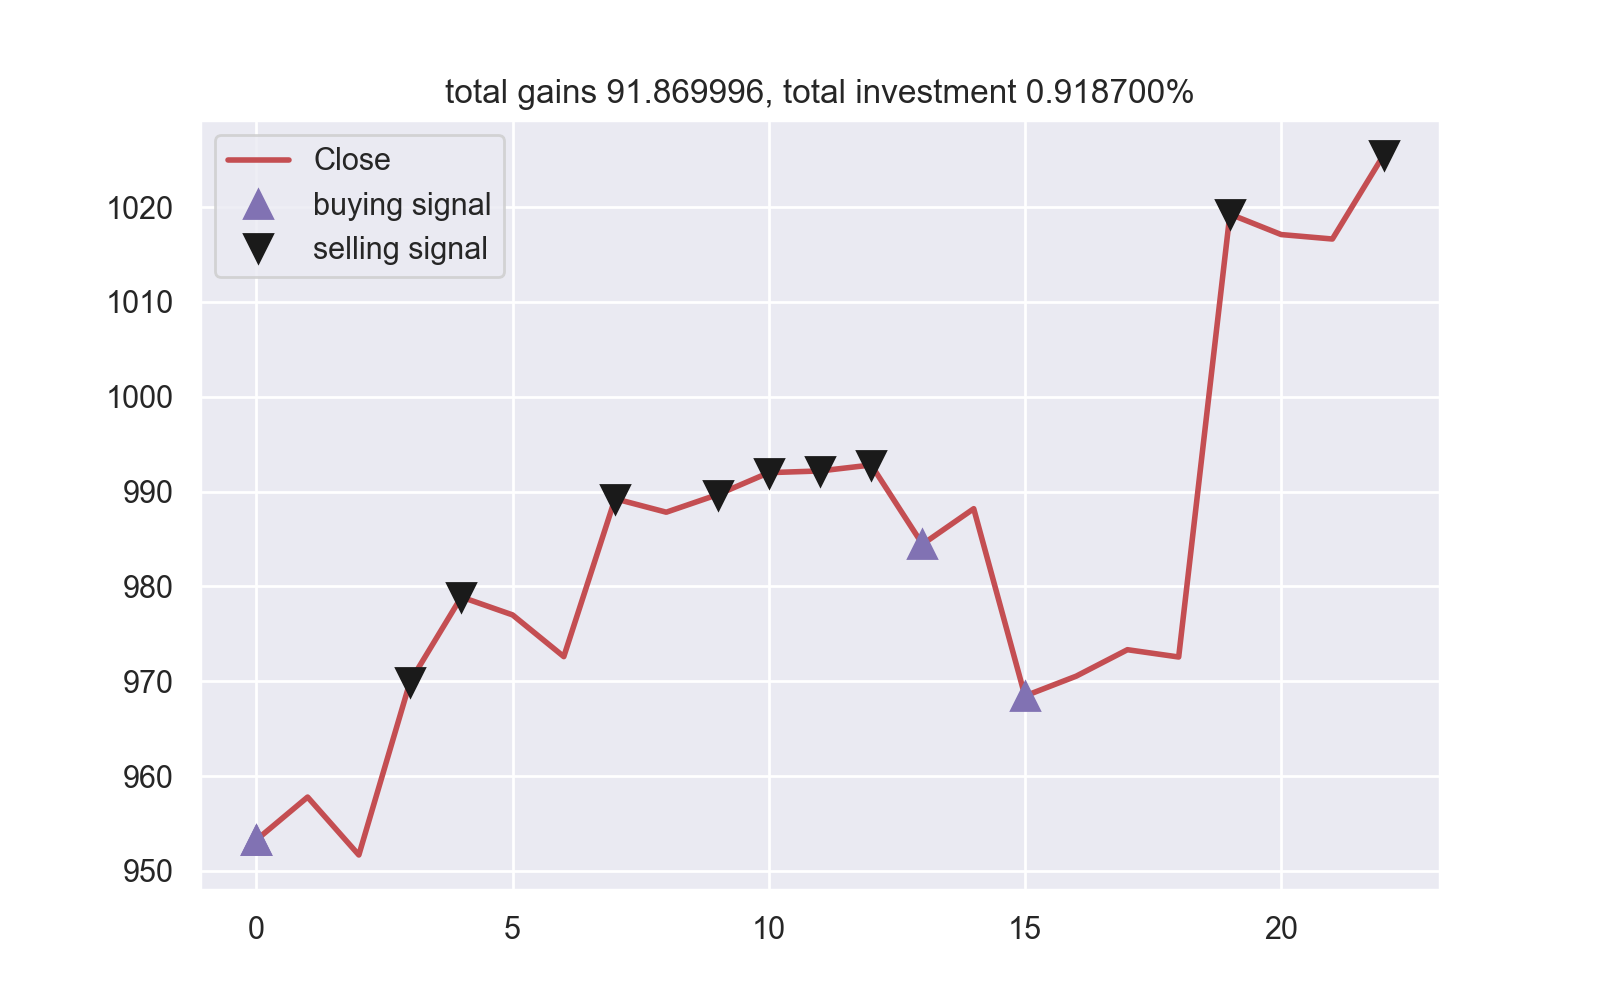

In [8]:
close = df['Close']
fig = plt.figure(figsize = (8,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()